# Set the project dir

In [5]:
import sys
import os
from pathlib import Path

# Get the absolute path of the project root
ROOT_DIR = Path(os.getcwd()).parent  # Moves up to FOOTBALLAI_ENDPROJECT

# Add ROOT_DIR to sys.path
sys.path.append(str(ROOT_DIR))

In [6]:
import importlib
import config.paths
importlib.reload(config.paths)  # Forces Python to reload the updated file
from config.paths import paths

print('\n'.join(f'{key}: {value}' for key, value in paths.items()))

HOME: C:\Users\miki0\OneDrive\Pulpit\FootballAI_EndProject
DATA: C:\Users\miki0\OneDrive\Pulpit\FootballAI_EndProject\data


# Install Dependencies

In [7]:
%pip install -q gdown inference-gpu
%pip install -q onnxruntime-gpu==1.18.0 --index-url https://aiinfra.pkgs.visualstudio.com/PublicPackages/_packaging/onnxruntime-cuda-12/pypi/simple/

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [8]:
%pip uninstall -y supervision && pip install -q supervision>=0.23.0

Found existing installation: supervision 0.25.1
Uninstalling supervision-0.25.1:
  Successfully uninstalled supervision-0.25.1
Note: you may need to restart the kernel to use updated packages.


# Download few videos

In [9]:
ORIGIN_VIDEO_DIR = paths['DATA'] / 'origin_videos'  # Path where the original videos will be saved
ORIGIN_VIDEO_DIR.mkdir(parents=True, exist_ok=True)  # Make dir 'origin_video'

!gdown -O "{ORIGIN_VIDEO_DIR}/0bfacc_0.mp4" "https://drive.google.com/uc?id=12TqauVZ9tLAv8kWxTTBFWtgt2hNQ4_ZF"
!gdown -O "{ORIGIN_VIDEO_DIR}/2e57b9_0.mp4" "https://drive.google.com/uc?id=19PGw55V8aA6GZu5-Aac5_9mCy3fNxmEf"
!gdown -O "{ORIGIN_VIDEO_DIR}/08fd33_0.mp4" "https://drive.google.com/uc?id=1OG8K6wqUw9t7lp9ms1M48DxRhwTYciK-"
!gdown -O "{ORIGIN_VIDEO_DIR}/573e61_0.mp4" "https://drive.google.com/uc?id=1yYPKuXbHsCxqjA9G-S6aeR2Kcnos8RPU"
!gdown -O "{ORIGIN_VIDEO_DIR}/121364_0.mp4" "https://drive.google.com/uc?id=1vVwjW1dE1drIdd4ZSILfbCGPD4weoNiu"

Downloading...
From: https://drive.google.com/uc?id=12TqauVZ9tLAv8kWxTTBFWtgt2hNQ4_ZF
To: C:\Users\miki0\OneDrive\Pulpit\FootballAI_EndProject\data\origin_videos\0bfacc_0.mp4

  0%|          | 0.00/19.9M [00:00<?, ?B/s]
  3%|▎         | 524k/19.9M [00:00<00:09, 2.01MB/s]
 21%|██        | 4.19M/19.9M [00:00<00:01, 13.0MB/s]
 32%|███▏      | 6.29M/19.9M [00:00<00:00, 14.9MB/s]
 42%|████▏     | 8.39M/19.9M [00:00<00:00, 15.6MB/s]
 53%|█████▎    | 10.5M/19.9M [00:00<00:00, 11.8MB/s]
 71%|███████   | 14.2M/19.9M [00:01<00:00, 16.6MB/s]
 82%|████████▏ | 16.3M/19.9M [00:01<00:00, 16.3MB/s]
 95%|█████████▍| 18.9M/19.9M [00:01<00:00, 17.5MB/s]
100%|██████████| 19.9M/19.9M [00:01<00:00, 14.6MB/s]


^C


Downloading...
From: https://drive.google.com/uc?id=19PGw55V8aA6GZu5-Aac5_9mCy3fNxmEf
To: C:\Users\miki0\OneDrive\Pulpit\FootballAI_EndProject\data\origin_videos\2e57b9_0.mp4

  0%|          | 0.00/21.1M [00:00<?, ?B/s]
  7%|▋         | 1.57M/21.1M [00:00<00:01, 14.2MB/s]
 27%|██▋       | 5.77M/21.1M [00:00<00:00, 29.3MB/s]
 45%|████▍     | 9.44M/21.1M [00:00<00:00, 30.2MB/s]
 65%|██████▍   | 13.6M/21.1M [00:00<00:00, 32.3MB/s]
 82%|████████▏ | 17.3M/21.1M [00:00<00:00, 32.2MB/s]
 99%|█████████▉| 21.0M/21.1M [00:00<00:00, 27.9MB/s]
100%|██████████| 21.1M/21.1M [00:00<00:00, 28.8MB/s]
Downloading...
From: https://drive.google.com/uc?id=1OG8K6wqUw9t7lp9ms1M48DxRhwTYciK-
To: C:\Users\miki0\OneDrive\Pulpit\FootballAI_EndProject\data\origin_videos\08fd33_0.mp4

  0%|          | 0.00/19.9M [00:00<?, ?B/s]
  5%|▌         | 1.05M/19.9M [00:00<00:02, 9.37MB/s]
 16%|█▌        | 3.15M/19.9M [00:00<00:01, 14.6MB/s]
 26%|██▋       | 5.24M/19.9M [00:00<00:00, 16.4MB/s]
 37%|███▋      | 7.34M/19.9M [

# Annotating frames with YOLO


## Test frame

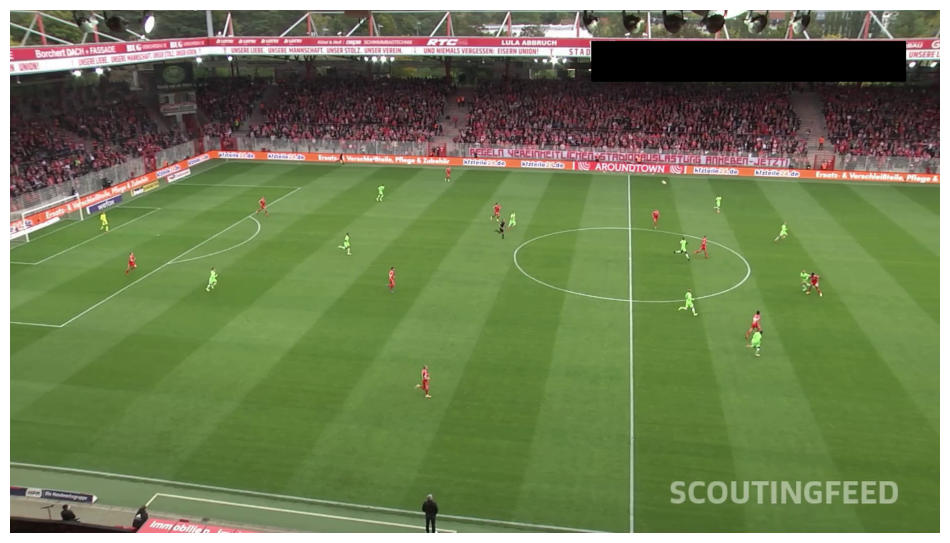

In [13]:
import supervision as sv

TEST_VIDEO_PATH = ORIGIN_VIDEO_PATH / '121364_0.mp4'

frame_generator = sv.get_video_frames_generator(TEST_VIDEO_PATH)
frame = next(frame_generator)

sv.plot_image(frame)

## train, valid, test split video

In [16]:
from tqdm import tqdm
import cv2
import os
import shutil
import random

# --------------------------------MAKING IMAEGS FROM VIDEOS--------------------------------
def images_from_video(video_paths: list[Path], output_path: Path, start_idx: int=0):
    '''
    Processes a list of video paths, extracting frames from each video and saving them as images

    Args:
        video_paths (list[Path]): A list of paths to video files. Each path must be a 'Path' object.
        output_path (Path): Path to directory where frames will be saved in .jpg format. Must be a 'Path' object.
        start_idx (int): Starting index for frame numbering. Defaults start_idx=0.
    '''

    video_idx = start_idx
    for idx, video_path in enumerate(video_paths):
        # get the video info to extract total number of frames
        video_info = sv.VideoInfo.from_video_path(str(video_path))
        # Frame generator
        frame_generator = sv.get_video_frames_generator(str(video_path))

        # Process each frame
        for frame in tqdm(frame_generator, total=video_info.total_frames, desc=f'VIDEO_{idx + 1}'):
            target_image_path = output_path / f'image_{video_idx:04d}.jpg'  # Path to save the frame f.g. frame_1234.jpg
            # Save the frame as an image_1234.jpg format
            cv2.imwrite(str(target_image_path), frame)
            video_idx += 1
# --------------------------------MAKING IMAGES FROM VIDEOS--------------------------------

# -------------------------------SPLITTING ALL IMAGES INTO TRAIN, VALID AND TEST DIR-------------------------------
def split_images_into_sets(images_dir: Path, train_ratio: float=0.8, validation_ratio: float=0.1):
    # Load the image file names
    images_list = [file for file in os.listdir(str(images_dir)) if file.endswith('.jpg')]
    # Shuffle images
    random.shuffle(images_list)
    
    # Count the number of images in train and valid sets
    total_images = len(images_list)  # number of total images
    train_num = int(total_images * train_ratio)  # number of train images
    valid_num = int(total_images * validation_ratio)  # number of valid images

    # Split the list into train, valid and test sets
    train_images = images_list[:train_num]  # train set
    valid_images = images_list[train_num: train_num + valid_num]  # valid set
    test_images = images_list[train_num + valid_num:]  # test set

    # Paths where images will be splitted into train, valid and test folders
    train_dir = images_dir / 'train'  # path to train folder
    valid_dir = images_dir / 'valid'  # path to validate folder
    test_dir = images_dir / 'test'  # path to test folder
    # Make train, valid and test dir - if doesn't exist
    train_dir.mkdir(parents=True, exist_ok=True)
    valid_dir.mkdir(parents=True, exist_ok=True)
    test_dir.mkdir(parents=True, exist_ok=True)
    
    # Move the images
    for image_file in train_images:
        shutil.move(str(images_dir / image_file), str(train_dir / image_file))
    
    for image_file in valid_images:
        shutil.move(str(images_dir / image_file), str(valid_dir / image_file))

    for image_file in test_images:
        shutil.move(str(images_dir / image_file), str(test_dir / image_file))
# -------------------------------SPLITTING ALL IMAGES INTO TRAIN, VALID AND TEST DIR-------------------------------

In [14]:
# --------------------------------MAKING IMAGES FROM VIDEOS--------------------------------
ORIGIN_VIDEOS_DIR = paths['DATA'] / 'origin_videos'
ANNOTATED_IMAGES_DIR = paths['DATA'] / 'annotated_imageS'  # Path where the annotated frames and annotations will be saved
ANNOTATED_IMAGES_DIR.mkdir(parents=True, exist_ok=True)  # Make dir 'annotated_image'

# List of each video paths
video_paths = [
    ORIGIN_VIDEOS_DIR / video_name 
    for video_name 
    in os.listdir(ORIGIN_VIDEOS_DIR)
]

images_from_video(video_paths, ANNOTATED_IMAGES_DIR)
# --------------------------------MAKING IMAGES FROM VIDEOS--------------------------------

# -------------------------------SPLITTING ALL IMAGES INTO TRAIN, VALID AND TEST DIR-------------------------------
split_images_into_sets(ANNOTATED_IMAGES_DIR, train_ratio=0.8, validation_ratio=0.1)
# -------------------------------SPLITTING ALL IMAGES INTO TRAIN, VALID AND TEST DIR-------------------------------

NameError: name 'images_from_video' is not defined

In [8]:
split_images_into_sets(ANNOTATED_IMAGES_DIR)

## Define model to annotate

In [5]:
import config.secrets
importlib.reload(config.secrets)  # Forces Python to reload the updated file
from config.secrets import ROBOFLOW_API_KEY
from inference import get_model

# ----------------PRETRAINED YOLOv8x to detect the players on the ptch----------------
PLAYER_DET_MODEL_ID = 'football-players-detection-3zvbc/11'
PLAYER_DET_MODEL = get_model(api_key=ROBOFLOW_API_KEY, model_id=PLAYER_DET_MODEL_ID)
# ----------------PRETRAINED YOLOv8x to detect the players on the ptch----------------

In [6]:
result = PLAYER_DET_MODEL.infer(frame)[0]
detections = sv.Detections.from_inference(result)

In [7]:
detections

Detections(xyxy=array([[1378.,  576., 1420.,  633.],
       [ 184.,  414.,  205.,  460.],
       [1412.,  466., 1443.,  514.],
       [ 238.,  501.,  262.,  549.],
       [1578.,  439., 1607.,  483.],
       [ 756.,  360.,  774.,  397.],
       [1642.,  542., 1678.,  593.],
       [ 835.,  733.,  871.,  802.],
       [ 404.,  531.,  430.,  581.],
       [1370.,  469., 1405.,  521.],
       [ 991.,  398., 1015.,  438.],
       [ 676.,  460.,  706.,  508.],
       [ 999.,  432., 1026.,  474.],
       [1325.,  411., 1342.,  454.],
       [1026.,  416., 1045.,  455.],
       [ 780.,  530.,  797.,  585.],
       [ 507.,  386.,  535.,  427.],
       [ 897.,  325.,  911.,  356.],
       [1454.,  381., 1470.,  421.],
       [1517.,  620., 1553.,  691.],
       [ 673.,  293.,  691.,  322.],
       [1344.,  352., 1356.,  363.]]), mask=None, confidence=array([0.92665613, 0.92325753, 0.91973376, 0.91591454, 0.91462463,
       0.91420686, 0.91155249, 0.91140991, 0.90719175, 0.90270472,
       0.900